# Moving Target from Scratch

## Introduction

This tutorial provides a running example showcasing the behavior of [the Moving Target algorithm](https://arxiv.org/abs/2002.10766), in a very simple setting. Moving Targets (MT) is a decomposition-based approach that enables injecting constraints at trainign time in models for supervised Machine Learnig learning. For example, it allows one to add fairness restrictions in classifiers, or take into account limitations due to physical laws in regression problems.

MT achives this by alternating "learner" steps, focusing on approximating a given target vector (i.e. a traditional ML task) and "master" steps, focusing on adjusting the target vector according to the constraints, the available data, and the current estimates from the ML model. The "moving" target vector gives the method its name. 

Since master and learner step communicate only through the target vector, you are free to pick any kind of technology to address them: you can use Neural Networks or Randon Forests for the learnign, and anything from Projected Gradient to powerful Mathematical Programming solvers for the master. In this way, MT enables taking advatage of decades of research in constraint optimization, without needed to make changes to actual learning algorithms.


## The Toy Learning Problem

This tutorial addresses a toy regression problem with just two examples (data points), as the accurate visualization is possible. Moreover, we will discuss only one of two forms of the problem solved by MT in the master steps.

In particular, we will assume we want to fit a model in the form:
$$
\tilde{f}(x, \alpha) = x^\alpha
$$
based on two observations. This is a simple curve fitting problem, whereas the MT algorithm can deal with most supervised learning approaches in ML. That said, the problem simplicity will help making clear how the mthod works.


The following cell defines the values of $x$ and $y$ for the two measured data points, i.e. $\hat{x}$ and $\hat{y}$

In [17]:
import numpy as np

# Measured data points
xm = np.array([1.5, 3])
ym = np.array([1.2, 2.2])

In our example we will assume we known the actual data generation process (i.e. the true curve): since this is something that would never be available in real life, we will use it only to judge the quality of our fit and see how well the different approaches we try are working.

In particular, the true curve in our case is given by:
$$
f(x) = x^{0.579} 
$$

In the following cell we use an unnamed (lamnda) function to define the curve and we obtain the true $y$ values for the our measurement points.

In [18]:
# True data source
f_true = lambda x: x**0.579

yt = f_true(xm)
yt

array([1.26461066, 1.88909242])

We can now plot both the true curve and the measured $x, y$ points:

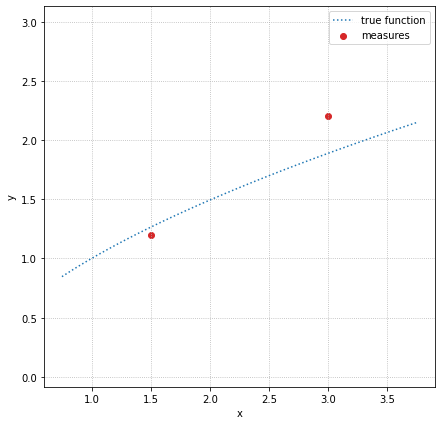

In [19]:
from matplotlib import pyplot as plt

def function_plot(xm, ym, f_true=None, f_pred=None):
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(xm, ym, color='tab:red', label='measures')
    span = xm[1] - xm[0]
    x = np.linspace(xm[0] - 0.5*span, xm[1] + 0.5*span)
    if f_true is not None:
        plt.plot(x, f_true(x), linestyle=':', color='tab:blue', label='true function')
    if f_pred is not None:
        plt.plot(x, f_pred(x), color='tab:orange', label='estimated function', linestyle=':')
        plt.scatter(xm, f_pred(xm), color='tab:orange', label='predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(linestyle=':')
    plt.axis('equal')
    plt.legend()

function_plot(xm, ym, f_true)

As we can see, our original measurements were a bit off: this happens all the time in the real world due to (e.g.) measurement noise, malfunctioning sensors, or typing errors.

More importantly, however, in this particular case we got a bit unlucky, since we have a small understimation for the first measurement and some overestimation for the second one. This would likely lead an ML approach to thinking that the curve grows at a pace larger than the true one, which is exactly what we proceed to verify:

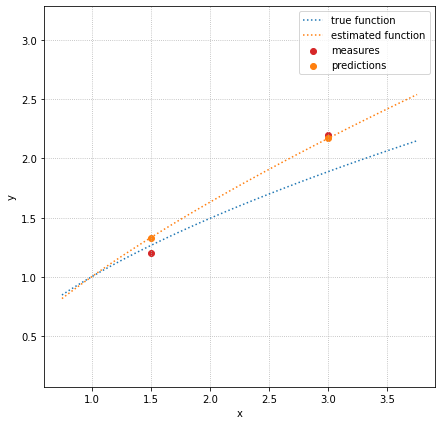

In [20]:
from scipy.optimize import curve_fit

def learner_step(xm, ym):
    f = lambda x, a: x**a
    p = curve_fit(f, xm, ym)
    a_opt = p[0][0]
    return lambda x: x**a_opt

f_pred = learner_step(xm, ym)
function_plot(xm, ym, f_true, f_pred)

We trained the model using a simple MSE loss, i.e. a basic supervised Machine Learning setup. The process is encapsulated in a function because it will double as our "learner step" in the implementation of the MT method.

As you can see, the learned model does indeed overstimate the curve slope.

More data would likely fix the issue in this case, but more data is not always avaialable. Indeed, poor fits are a problem in many industrial use cases where data is scarce or noisy. 

## Taking Advantage of Constraints

Now, let's assume we know that the curve value for our two measurements must obey:
$$
y_1 \leq \frac{3}{2} y_0
$$
in a real world setup, this information may come from example from physical limits or laws applicable to the considered process.

How do we take advantage of the constraint? The MT algorithm does so by reasoning in _output space_, i.e. in the space of all possible output for the ML model. In our case, this would be a plane where one axis corresponds to $y_0$ and the other to $y_1$.

In this representation, both the measured values and our current predictions _would appear as points_, respectively $(\hat{y}_0, \hat{y}_1)$ and $(\tilde{y}_0, \tilde{y}_1)$:

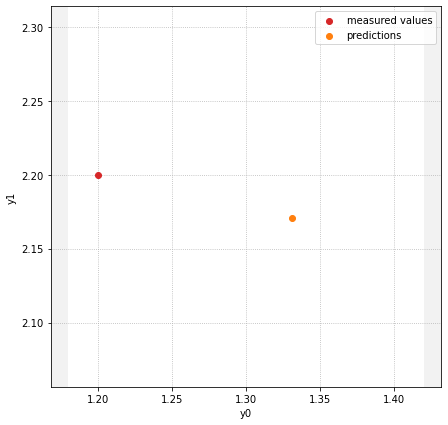

In [21]:
def output_plot(xm, ym, yp, f_bound=None, yf=None, plot_bias=False):
    fig = plt.figure(figsize=(7, 7))
    y0 = np.linspace(ym[0] - 0.02, ym[0] + 0.22)
    y1 = xm[1]**(np.log(y0) / np.log(xm[0]))
    plt.gca().set_facecolor((0.95, 0.95, 0.95))
    plt.axvspan(y0[0], y0[-1], color='white')
    if plot_bias:
        plt.plot(y0, y1, color='tab:orange', label='ML model bias')
    plt.scatter(ym[0], ym[1], color='tab:red', label='measured values', zorder=2)
    if yp is not None:
        yp = np.array(yp).reshape(-1, 2)
        plt.scatter(yp[:, 0], yp[:, 1], color='tab:orange', label='predictions', zorder=2)
    ylim = None
    if f_bound:
        y1_bound = f_bound(y0)
        ylim = plt.ylim()
        plt.fill_between(y0, ylim[0], y1_bound, zorder=2, alpha=0.2, label='feasible output')
    if yf is not None:
        yf = np.array(yf).reshape(-1, 2)
        plt.scatter(yf[:, 0], yf[:, 1], color='tab:blue', label='adjusted target', zorder=2)
    if yf is not None and yp is not None:
        tmp = np.empty((len(yp)+len(yf), yp.shape[1]))
        tmp[0::2, :] = yp
        tmp[1::2, :] = yf
        plt.plot(tmp[:, 0], tmp[:, 1], linestyle=':', color='0.5', zorder=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.grid(linestyle=':')
    plt.axis('equal')
    plt.legend()
    if ylim is not None:
        plt.ylim(*ylim)

yp = f_pred(xm)
output_plot(xm, ym, yp)

By changing the $\alpha$ parameter in out ML model we can change the prediction vector (the orange point in the plot), but only in a way that is consistent with the ML model that we are trying to fit, i.e. with the equation:
$$
y = x^\alpha
$$

Every $\alpha$ value will result in a different prediction vector (point in the plane): we can draw all of them, obtaing some kind of area or shape on the plane. In our case we will obtain a curve, since the ML model has a single parameter:

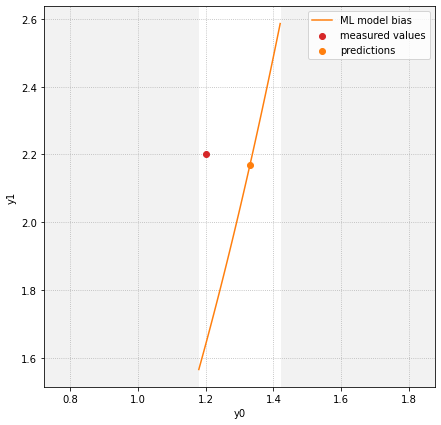

In [22]:
def output_plot(xm, ym, yp, f_bound=None, yf=None,):
    fig = plt.figure(figsize=(7, 7))
    y0 = np.linspace(ym[0] - 0.02, ym[0] + 0.22)
    y1 = xm[1]**(np.log(y0) / np.log(xm[0]))
    plt.gca().set_facecolor((0.95, 0.95, 0.95))
    plt.axvspan(y0[0], y0[-1], color='white')
    plt.plot(y0, y1, color='tab:orange', label='ML model bias')
    plt.scatter(ym[0], ym[1], color='tab:red', label='measured values', zorder=2)
    if yp is not None:
        yp = np.array(yp).reshape(-1, 2)
        plt.scatter(yp[:, 0], yp[:, 1], color='tab:orange', label='predictions', zorder=2)
    ylim = None
    if f_bound:
        y1_bound = f_bound(y0)
        ylim = plt.ylim()
        plt.fill_between(y0, ylim[0], y1_bound, zorder=2, alpha=0.2, label='feasible output')
    if yf is not None:
        yf = np.array(yf).reshape(-1, 2)
        plt.scatter(yf[:, 0], yf[:, 1], color='tab:blue', label='adjusted target', zorder=2)
    if yf is not None and yp is not None:
        tmp = np.empty((len(yp)+len(yf), yp.shape[1]))
        tmp[0::2, :] = yp
        tmp[1::2, :] = yf
        plt.plot(tmp[:, 0], tmp[:, 1], linestyle=':', color='0.5', zorder=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.grid(linestyle=':')
    plt.axis('equal')
    plt.legend()
    if ylim is not None:
        plt.ylim(*ylim)

yp = f_pred(xm)
output_plot(xm, ym, yp)

This curve (almost a straight line, in the considered range) represents the set of $(\tilde{y}_0, \tilde{y}_1)$ estimates that our ML model can output for the two measurements $(\hat{x}_0, \hat{x}_1)$. In Machine Leaerning terms, the curve represents the _bias_ of the model.

Notice how the measured output $\hat{y}$ does not fall within the bias? That means that the model structure we have chosen (the equation $y = x^\alpha$) is not capable of touching the two measurements.

Similarly to the ML model bias, our constraint:
$$
y_1 \leq \frac{3}{2} y_0
$$
identifies a second area on the plane, corresponding to the combinations of output values $(y_0, y_1)$ that are consistent with the inequality. The plotting function we are using can show this second area, too:

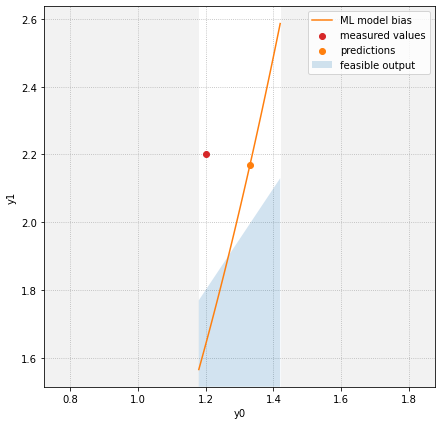

In [23]:
f_bound = lambda y0: 1.5*y0

output_plot(xm, ym, yp, f_bound)

So, from the point of view of the Moving Target method, both the ML model bias and the constraints can be seen as very similar objects, namely _sets in the output space_.

Our goal is finding a point that is:

* In the intersection of the orange and blue areas (ML model bias and feasible set)
* As close as possible in terms of loss to the red dot (the measured values)

In our picture, this is the point where the orange line first touches the blue area.

## Moving Targets

Now that we have clarified how different things (measured values, predictions, bias, constraints...) look in output space, we are ready to tackle the Moving Target method itself.

The algorithm alternates "learner steps", i.e. traditional Machine Learning tasks, and "master steps", where the target vector is adjusted to account for the constraints.

Usually, one starts with a learner step, such as the one we have already performed when training our ML model. If this step can be solved to optimality, as in our simple case, it will provide us with an output vector (predictions) that is as close as possible to the measured values, with closeness being measured in terms of the chosen loss function.


In the picture, we can see that the orange dot (model predictions) is simply the Euclidean projection of the red dot (measured values) on the orange line. The projection is Euclidean in this case since we chose the MSE as our loss function.

From this point, the MT method will run a master step. Technically, there are two distinct types of master step in MT, one applied when the prediction vector violates the constraints ($\alpha$ step) and one when it satisfies them ($\beta$ step).

In our case, the $\alpha$ step will be enough. This consists in finding a point in output space that is:

* Feasible according to the constraints
* Relatively close to _both_ the measured vector $\hat{y}$ and the prediction vector $\tilde{y}$

Once again, closeness is maesured in terms of the chosen loss function. The distance between $\hat{y}$ and $\tilde{y}$ is balanced using a parameter $\alpha$. In particular, we look for a feasible point that minimizes:
$$
L(y, \hat{y}) + \frac{1}{\alpha} L(y, \tilde{y})
$$

This is a constrained optimization problem, defined _entirely in output space_. In practice, it means that:

* We don't have to deal with the ML model when considering the constraints. This is super handy since ML models can be large and rather nasty to take into account in constrained optimization.
* We can solve the problem with any technique that makes sense, ranging from classical numerical optimization methods to powerful Mathematical Programming, Constraint Programming, or SAT Modulo Theory solvers.

In our case, te default solver for linearly constrained quadratic programming in scipy is enough:

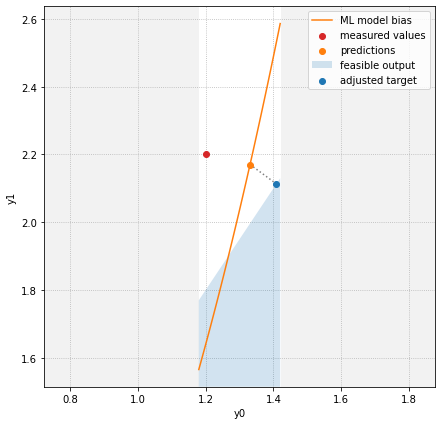

In [24]:
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

def master_step_alpha(ym, yp, alpha=0.1):
    cst = LinearConstraint([[1.5, -1]], 0, np.inf)
    obj = lambda y: np.square(y - ym).sum() + 1/alpha * np.square(y - yp).sum()
    res = minimize(obj, yp, constraints=[cst])
    return res.x

yp = f_pred(xm)
yf = master_step_alpha(ym, yp)

output_plot(xm, ym, yp, f_bound, yf=yf)

We chose a small $\alpha$, so the adjusted target vector (blue dot) almost matches the projection of the prediction vector (orange dot) on the feasible set (blue area). "Almost", since it is slighly nearer to the measured vector (red dot) than it should otherwise be: this is due to the $L(y, \hat{y})$ term in the cost function of the master step.

Picking a good value for $\alpha$ may require some trial and error: large values may not guarantee convergence (even in an all-convex case), while too small values may lead to slow convergence.

Now we can perform _a new learner step_ using the adjusted target vector as labels:

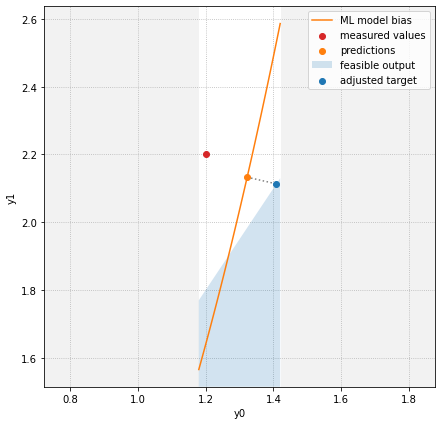

In [25]:
f_pred2 = learner_step(xm, yf)

yp2 = f_pred2(xm)
output_plot(xm, ym, yp2, f_bound, yf)

By doing so, we have obtained a new prediction vector, that is a bit closer to our goal.

Now we just need to repeat the process several time. We will define a Python function to do just that and see the result of the first few iterations:

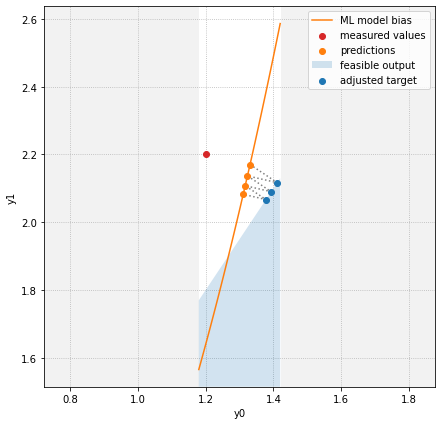

In [26]:
# Repeat the process
def moving_target_alpha(n):
    ypl = []
    yfl = []

    f_pred = learner_step(xm, ym)
    yp = f_pred(xm)
    ypl.append(yp)
    for i in range(n):
        # Master step
        yf = master_step_alpha(ym, yp, alpha=0.001)
        yfl.append(yf)
        # Learner stpe
        f_pred = learner_step(xm, yf)
        yp = f_pred(xm)
        ypl.append(yp)
    return ypl, yfl, f_pred

ypl, yfl, _ = moving_target_alpha(n=3)
output_plot(xm, ym, ypl, f_bound, yfl)

Notice how the method zig-zags ever closer to the best possible prediction vector.

If you know about numerical optimization this zig-zag behavior may look both bad and avoidable, but in practice it's the price we pay to keep the ML and the constraint handling parts completely separated, i.e. the main advantage of the MT method.

We can finally have a look at which kind of learned function we may obtain after enough iterations to get close to convergence. Here it comes:

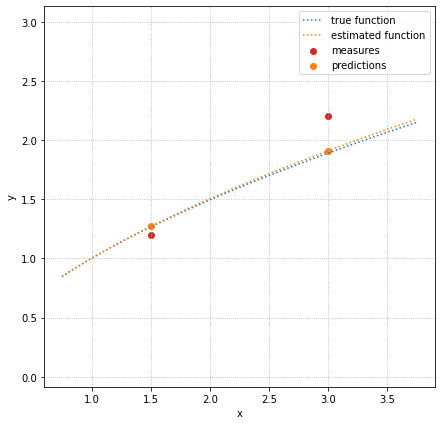

In [27]:
_, _, f_pred_final = moving_target_alpha(n=30)

function_plot(xm, ym, f_true, f_pred_final)

Thanks to the use of the additional constraint (basically: domain knowledge in symbolic form), we managed to get an estimated function that is very close to the true one.

Of couse this is a toy example designed to showcase this very behavior, so don't take this success too optimistically ;-)

## Conclusions

If things have gone as planned, you should now have a much better idea of how the Moving Target method works, and especially how things look like from the perspective of the output space.

Don't forget that the tutorial is focues on the $\alpha$ (or "infeasible") master step, so if you want to have a full picture ot the method you will need to [check the paper](https://arxiv.org/abs/2002.10766).

As a rule of thumb, using MT instead of other methods for injecting constraints in ML model may be interesting when:

* Your constraints are not natively differentiable (e.g. they are defined on discrete variables). You can just use a combinatorial solver with deal with them!
* Your constraints are defined on a large number of examples (e.g. fairness indicators). You can focus on tackling them in output space, without any possibly huge ML model in the way.
* Dealing with the constraint via alternative methods (e.g. regularization/Lagrangian approaches) slows down training a lot

MT is not a silver bullet, but we think it's a valuable tool to inject constraints in ML model. We hope you found this whole thing interesting as well :-)